In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 导入数据
housdata = fetch_california_housing()
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(housdata.data, housdata.target, test_size=0.3, random_state=42)
# 数据标准化处理
scale = StandardScaler()
X_train_s = scale.fit_transform(X_train)
X_test_s = scale.transform(X_test)
## 将训练数据集处理为数据表，方便查看数据情况
housdatadf = pd.DataFrame(data=X_train_s, columns=housdata.feature_names)
housdatadf["target"] = y_train

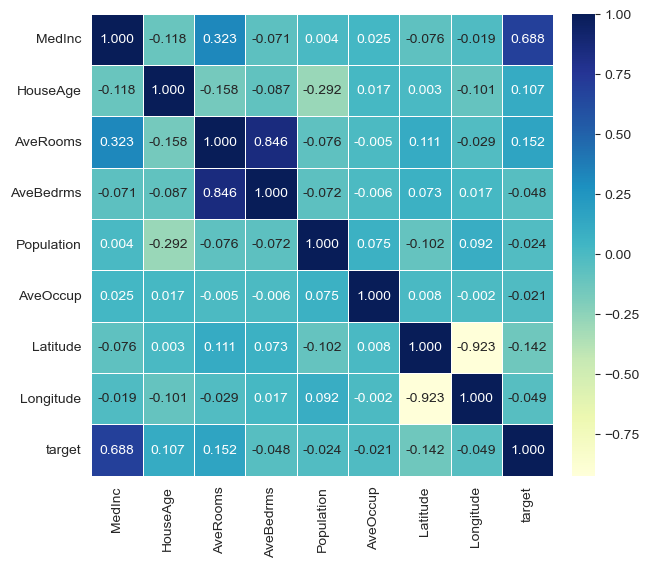

In [4]:
datacor = np.corrcoef(housdatadf.values, rowvar=False)
datacor = pd.DataFrame(data=datacor, columns=housdatadf.columns, index=housdatadf.columns)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(datacor, square=True, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu", cbar_kws={"fraction": 0.046, "pad": 0.03})
plt.show()

In [5]:
# 将数据集转化为张量
train_xt = torch.from_numpy(X_train_s.astype(np.float32))
train_yt = torch.from_numpy(y_train.astype(np.float32))
test_xt = torch.from_numpy(X_test_s.astype(np.float32))
test_yt = torch.from_numpy(y_test.astype(np.float32))
# 将训练集处理成数据加载器
train_data = Data.TensorDataset(train_xt, train_yt)
test_data = Data.TensorDataset(test_xt, test_yt)
train_loader = Data.DataLoader(dataset=train_data, batch_size=64, shuffle=True, num_workers=1)

In [6]:
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression, self).__init__()
        # 定义第一个隐藏层
        self.hidden1 = nn.Linear(in_features=8, out_features=100, bias=True)
        # 定义第二个隐藏层
        self.hidden2 = nn.Linear(100, 100)
        # 定义第三个隐藏层
        self.hidden3 = nn.Linear(100, 50)
        # 回归预测层
        self.predict = nn.Linear(50, 1)

    # 定义前向传播
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        output = self.predict(x)
        # 输出一个一维向量
        return output[:, 0]

mlpreg = MLPregression()
print(mlpreg)

MLPregression(
  (hidden1): Linear(in_features=8, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=1, bias=True)
)


In [9]:
# 定义优化器
optimizer = torch.optim.SGD(mlpreg.parameters(), lr=0.01)
loss_func = nn.MSELoss()  # 均方根误差损失函数
train_loss_all = []
# 对所有模型进行迭代训练，对所有的数据训练 epoch 轮
for epoch in range(30):
    train_loss = 0
    train_num = 0
    # 对训练数据的加载器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):
        output = mlpreg(b_x)  # MLP在训练batch上的输出
        loss = loss_func(output, b_y)  # 均方根误差损失函数
        optimizer.zero_grad()  # 每个迭代步的梯度初始化为0
        loss.backward()  # 损失的后向传播，计算梯度
        optimizer.step()  # 使用梯度进行优化
        train_loss += loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    train_loss_all.append(train_loss / train_num)

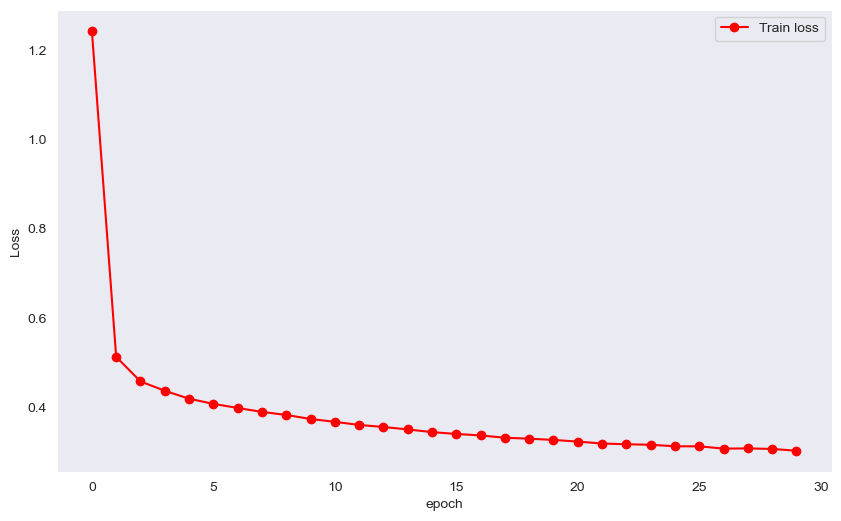

In [10]:
# 可视化损失函数的变化情况
plt.figure(figsize=(10, 6))
plt.plot(train_loss_all, "ro-", label = "Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

In [13]:
# 对测试集进行预测
pre_Y = mlpreg(test_xt)
pre_Y = pre_Y.data.numpy()
mae = mean_absolute_error(y_test, pre_Y)
print("在测试集上的绝对值误差为 :", mae)

在测试集上的绝对值误差为 : 0.3920646556866754


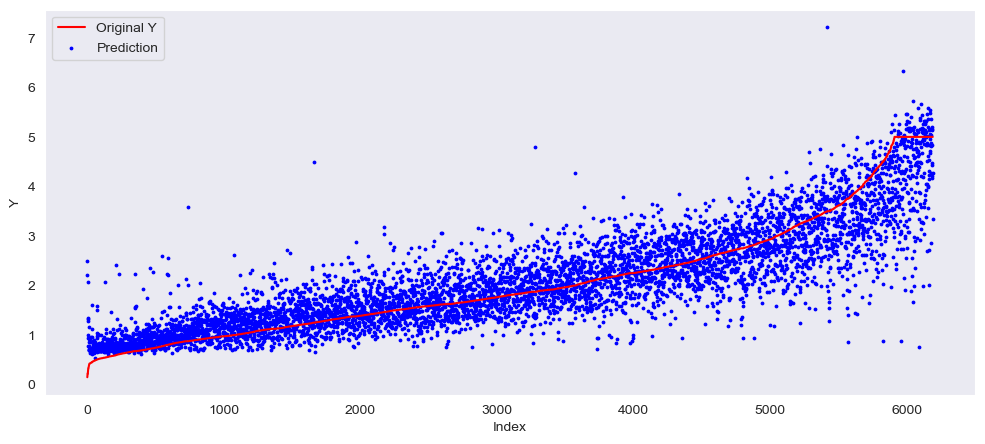

In [14]:
# 可视化在测试集上真实值和预测值的差异
index = np.argsort(y_test)
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(y_test)), y_test[index], "r", label="Original Y")
plt.scatter(np.arange(len(pre_Y)), pre_Y[index], s=3, c="b", label="Prediction")
plt.legend(loc="upper left")
plt.grid()
plt.xlabel("Index")
plt.ylabel("Y")
plt.show()